In [85]:
import CVIs
import helper
import methods 


In [86]:
import inspect

functs = [f for _, f in inspect.getmembers(methods, inspect.isfunction)]

print(functs)

for fn in functs:
    vars = fn.__code__.co_varnames
    print(vars)


[<function CAL at 0x133768d30>, <function K_means at 0x133768af0>, <function LCCV at 0x133768c10>, <function PCKM at 0x133768ca0>, <function average_linkage at 0x133768b80>, <function computeClusterSim1 at 0x132c29790>, <function computeMySWC at 0x132b105e0>, <function euclidean_distances at 0x12890a4c0>, <function fcluster at 0x132b0ea60>, <function linkage at 0x132b0f940>, <function silhouette_index_terms at 0x133761e50>]
('data', 'K', 'ML', 'CL')
('data', 'K')
('data', 'N', 'n', 'dist', 's_dist', 'index', 'r', 'nb', 'count1', 'flag', 'RNN', 'i', 'k', 'count2', 'lambda_r', 'max_nb', 'rho', 'Non', 'd', 'ord_rho', 'local_core', 'p', 'neighbourhood', 'qq', 'max_index', 'j', 'q', 'm', 'cores', 'cluster_number', 'cl', 'conn', 'weight', 'x', 'shortest_path', 'weight2', 'max_d', 'results', 'cdata', 'nc', 'this_cluster', 'sim', 'small_threshold', 'clunum2', 'v', 'ic', 'mcv', 'clunum', 'ls_row', 'index_rows', 'idy', 'idx', 'pp', 'cls', 'cv', 'bestcvi', 'id', 'bestcl')
('data', 'K', 'ML', 'CL'

In [87]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt

def computeClusterSim1(cdata:dict, conn:np.array, cluster_number:int) -> np.array:
    sim = np.zeros((cluster_number, cluster_number))
    for i in np.arange(cluster_number-1):
        for j in np.arange(i+1, cluster_number):
            t = conn[cdata[i],:][:,cdata[j]] # all edges in the two clusters
            nnn = np.sum(t.flatten() > 0)
            if nnn:
                sim[i,j] = (np.sum(t.flatten())**3)/nnn**2
                sim[j,i] = sim[i,j]
    return sim

def computeMySWC(A,cl,cores,pdist,local_core):
    ncores = len(cores)
    D = A[cores,:] # extract all cores
    cl_cores = cl[cores]
    ncl = list(Counter(local_core).values()) # counts the elements' frequency# the number of points belining to each core
    ncl[ncl == 0] = 0 ## Is this really needed here? 

    # silhouette of the cores and their cluster labels
    np.fill_diagonal(pdist, 0)
    
    _,s = silhouette_index_terms(D,cl_cores,pdist)

    mcv = 0
    for i in np.arange(ncores):
        
        mcv = mcv + s[i]*ncl[i]
    
    return mcv/A.shape[0]


def silhouette_index_terms(data,cluster_labels,d):
    uc = np.unique(cluster_labels)
    K = len(uc)

    if K == 1: # A single label
        cvi = 0
        cvi_terms = np.zeros(len(cluster_labels))
        return cvi, cvi_terms
    
    cvia = np.zeros(len(cluster_labels)) # array to store a's
    cvib = np.zeros(len(cluster_labels)) # array to store b's

    for i in np.arange(K):
        this_cluster = cluster_labels == uc[i]
        nk = np.sum(this_cluster)

        if nk > 1: # guard against one-element clusters
            #print('d[this_cluster, this_cluster] = ', d[this_cluster,:][:,this_cluster])
            cvia[this_cluster] = (np.mean(d[this_cluster,:][:,this_cluster], axis=1) * nk) / (nk-1)

            bb = np.array([])
            for j in np.arange(K):
                if i != j:
                    other_cluster = cluster_labels == uc[j]
                    if bb.shape[0] > 0:
                        bb = np.vstack((bb, np.mean(d[this_cluster,:][:,other_cluster], axis=1)))
                    else:
                        bb = np.mean(d[this_cluster,:][:,other_cluster], axis=1)
                        
            cvib[this_cluster] = np.min(bb, axis=0)
        else:
            ## She does not like one-element clusters to contribute to the silhouette index. We can take care of this right here
            # But why, on earth, does she wat to dicount clusters with one CORE
            cvia[this_cluster] = 1
            cvib[this_cluster] = 1
    
    vec = cvib - cvia
    max_vals = np.max(np.vstack((cvia,cvib)), axis=0)


    cvi_terms = [vec[i]/ max_vals[i] for i in np.arange(len(vec))]
    cvi = np.mean(cvi_terms)
    return cvi, cvi_terms


In [88]:
import os

def LCCV(data) -> np.array:
    
    N,n = data.shape
    dist = euclidean_distances(data,data)
    s_dist = np.sort(dist, axis=1)
    index = np.argsort(dist, axis=1)


    ### NaN-searching algorithm ###
    r = 1
    nb = np.zeros(N, dtype='int')
    count1 = 0
    flag = False
    RNN = np.zeros((N,N))
    while not flag:
        for i in np.arange(N):
            k = index[i, r+1]
            nb[k] += 1
            RNN[k,int(nb[k])] = i
        r += 1
        count2 = np.sum(nb == 0)
        if count2 == 0 or count1 == count2:
            flag = True
        else:
            count1 = count2

    lambda_r = r - 1
    max_nb = np.max(nb)


    # desnity of each point
    ### There is a discrepancy with the original paper! The author
    ### says that ONLY the distances of the reverse neighbours are
    ### added in the denominator. However, in their implementation,
    ### the MAX_NB are added, not just the reverse neighbours'!
    rho = np.zeros(N)
    Non = int(max_nb)
    for i in np.arange(N):
        d = np.sum(s_dist[i, 0:Non+1])
        
        rho[i] = Non/d

    ### LORE algorithm ###
    # sort the points according to the density
    # rho_sorted = np.sort(rho)[::-1]

    #print(len(np.unique(rho)))
    ord_rho = np.argsort(rho)[::-1]

    local_core = np.zeros(N, dtype='int')
    for i in np.arange(N):
        p = ord_rho[i]
        neighbourhood = index[p, 0:nb[p]+1]

        qq = np.argmax(rho[neighbourhood])
        max_index = neighbourhood[qq]

        if local_core[max_index] == 0:
            local_core[max_index] = max_index

        
        for j in np.arange(nb[p]+1):
            j = int(j)
            if local_core[neighbourhood[j]] == 0:
                local_core[neighbourhood[j]] = local_core[max_index]
            else: # RCR rule
                q = int(local_core[neighbourhood[j]])
            
                if dist[neighbourhood[j], q] > dist[neighbourhood[j], int(local_core[max_index])]:
                    local_core[neighbourhood[j]] = local_core[max_index]
            # Determine the representative according to RTR
            for m in np.arange(N):
                if local_core[m] == neighbourhood[j]:
                    local_core[m] = local_core[neighbourhood[j]]

    # find the cores
    cores = np.unique(local_core)
    cluster_number = len(cores)
    cl = local_core.copy()

    # Graph based distances (Connectivity)
    conn = np.zeros((N,N))
    weight = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(1, lambda_r+1):
            x = index[i,j]
            conn[i,x] = 1/(1+dist[i,x])
            conn[x,i] = conn[i,x]
            weight[i,x] = dist[i,x]

    # comput the shortest path between cores
    shortest_path = np.zeros((cluster_number,cluster_number))
    weight2 = nx.DiGraph(weight)

    for i in np.arange(cluster_number):
        shortest_path[i,i] = 0
        for j in np.arange(i+1,cluster_number):
            
            try:
                shortest_path[i,j] = nx.dijkstra_path_length(weight2, cores[i], cores[j])
            except nx.NetworkXNoPath:
                shortest_path[i,j] = 0

            shortest_path[j,i] = shortest_path[i,j]
    max_d = np.max(shortest_path)
    shortest_path[shortest_path == 0] = max_d

    results = {}

    # Compute the similarity between clusters
    cdata = {} # create a dictionary to stor the points in each cluster
    nc = np.zeros(cluster_number)
    for i in np.arange(cluster_number):
        this_cluster = (cl == cores[i])
        nc[i] = np.sum(this_cluster)
        cdata[i] = np.asarray(this_cluster).nonzero()[0]

    sim = computeClusterSim1(cdata,conn,cluster_number)

    results[0] = {'cdata':cdata, 'cl':cl}

    # Merge the small clusters ------
    small_threshold = N/cluster_number
    clunum2 = cluster_number
    for i in np.arange(cluster_number):
        if nc[i] <= small_threshold:
            # find the most similar cluster

            v, ic = np.max(sim[i,:]), np.argmax(sim[i,:])

            # If there are no clusters conncting the small clusters
            # the small clusters are considered as outliers
            # ----- label 0
            if v == 0 and nc[i] < small_threshold/2:
                cl[cdata[i]] = 0 # should this be -1 for python???
                cdata[i] = []
                nc[i] = 0
                clunum2 = clunum2 - 1
            
            if v > 0:
                clunum2 = clunum2 - 1
                # merge the clusters
                cdata[ic] = np.append(cdata[ic], cdata[i], axis=0)
                nc[ic] = nc[ic] + nc[i]
                nc[i] = 0
                cdata[i] = []

                # update sim
                sim = computeClusterSim1(cdata, conn, cluster_number)

    # obtain the clustering results after merging small clusters
    for i in np.arange(cluster_number):
        cl[cdata[i]] = i

    # pack the cluster numbers
    for i in np.arange(cluster_number):
        if nc[i] == 0:
            for j in np.arange(i+1,cluster_number):
                cl[cdata[j]] = cl[cdata[j]] - 1

    # data - data set
    # cl - cluster labels in the reduced nubmer of clusters (1, 2, ...)
    # clunum2 - reduced number of clusters
    # cores - the original number of cores
    # short_path - the shortest path between original cores
    # local_core - cl before they were reduced and relabelled ?

    mcv = computeMySWC(data,cl,cores.astype(int),shortest_path,local_core)

    results[cluster_number - clunum2] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum2}

    ## Now the algorithm itself
    clunum = clunum2

    while clunum > 2:

        # store the results
        results[cluster_number - clunum] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum}
        
        # find the two clusters with the largest similarity
        ls_row, index_rows = np.max(sim, axis=0), np.argmax(sim,axis=0)
        idy = np.argmax(ls_row)
        idx = index_rows[idy]

        results[cluster_number - clunum ]['merge'] = [idx,idy]

        # merge the clusters
        if idx != idy:
            pp = np.sort([idx,idy])
            idx, idy = pp[0], pp[1]
            cdata[idx] = np.append(cdata[idx], cdata[idy], axis=0)
            nc[idx] = len(cdata[idx])
            cdata[idy] = []
            nc[idy] = 0
            clunum = clunum - 1

            # update sim
            sim = computeClusterSim1(cdata,conn,cluster_number)

            # obtain the clustering results
            for i in np.arange(cluster_number): # renumber the clusters
                cl[cdata[i]] = i

            # pack the cluster numbers
            for i in np.arange(cluster_number):
                if nc[i] == 0:
                    for j in np.arange(i+1,cluster_number):
                        cl[cdata[j]] = cl[cdata[j]] - 1
            
            mcv = computeMySWC(data,cl,cores.astype(int),shortest_path,local_core)

            if clunum == 2:
                results[cluster_number - clunum] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum}
        else:
            results[cluster_number -  2] = {'cdata':[],'cl':[],'sim':[],'mcv':[]}
            break

    # obtain the best clustering results from a series of results

    cls = []
    cv = []

    for i in results.keys():
        if 'mcv' in results[i]:
            cv.append(results[i]['mcv'])
            cls.append(results[i]['cl'])

    bestcvi, id = np.max(cv), np.argmax(cv) # best value of the CVI
    bestcl = cls[id] # correspoinding labels

    return bestcl, bestcvi, results



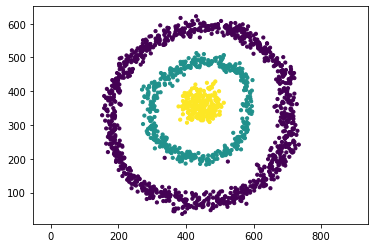

In [90]:
data = pd.read_csv('../datasets/circle.csv', header=None)
data = np.asarray(data)

bestcl, bestcvi, results = LCCV(data)

plt.figure()
plt.axis('equal')
plt.scatter(data[:,0], data[:,1], 10, bestcl)

In [136]:
import re
import json

RESULTS = '../results'

k_means_results, single_linkage_results = [], []

for folder in sorted(os.listdir(RESULTS)): # list all folders inside the results folder

    pattern = re.compile("^NP+")
    if pattern.match(folder): # if the folder matches the pattern 'NP_...'
        ALGORITHMS = RESULTS + '/' + folder
        for alg in sorted(os.listdir(ALGORITHMS)):

            alg_results = []

            CVIS = ALGORITHMS + '/' + alg
            for cvi in sorted(os.listdir(CVIS)):

                cvi_pattern = re.compile('.*?.csv$')
                if not cvi_pattern.match(cvi):

                    CVI_FOLDER = CVIS + '/' + cvi
                    for data_loc in sorted(os.listdir(CVI_FOLDER)):
                        data_pattern = re.compile('.*?.txt$')
                        if data_pattern.match(data_loc):

                            with open(CVI_FOLDER + '/' + data_loc) as infile:
                                data = json.load(infile)
                                alg_results.append(data['NMI'])
            
            if alg == 'K_means':
                k_means_results.append(alg_results)
            else:
                single_linkage_results.append(alg_results)

kmr, slr = np.asarray(k_means_results), np.asarray(single_linkage_results)



In [192]:
import scipy.stats as st
import pandas as pd

legend = sorted(os.listdir('../results/NP_100/K_means'))

cvi_pattern = re.compile('.*?.csv$')

legend_vals = [cvi for cvi in legend if not cvi_pattern.match(cvi)]

km_df = pd.DataFrame()
sl_df = pd.DataFrame()

for i in np.arange(kmr.shape[1]):

    # Calculate the confidence interval
    KM_CI_95 = st.norm.interval(alpha=0.95, loc=np.mean(kmr[:,i]), scale=st.sem(kmr[:,i]))
    SL_CI_95 = st.norm.interval(alpha=0.95, loc=np.mean(slr[:,i]), scale=st.sem(slr[:,i]))

    km_rs = {'Mean_CVI': np.mean(kmr[:,i]), 'Standard_Deviation':np.std(kmr[:,i]), 'CI_lower':KM_CI_95[0], 'CI_higher':KM_CI_95[1]}
    sl_rs = {'Mean_CVI': np.mean(slr[:,i]), 'Standard_Deviation':np.std(slr[:,i]), 'CI_lower':SL_CI_95[0], 'CI_higher':SL_CI_95[1]}
    
    km_curr_df = pd.DataFrame(data=km_rs, index=[legend_vals[i]])
    sl_curr_df = pd.DataFrame(data=sl_rs, index=[legend_vals[i]])

    km_df = pd.concat([km_df, km_curr_df], ignore_index=False)    
    sl_df = pd.concat([sl_df, sl_curr_df], ignore_index=True) 
    

#pd.DataFrame(data=km, index=legend_vals)
#km_df = km_df.set_axis(legend_vals, axis='index')
sl_df = sl_df.set_axis(legend_vals, axis='index')
display(km_df)
display(sl_df)


,Mean_CVI,Standard_Deviation,CI_lower,CI_higher
LCCV_index,0.750010,0.199973,0.708465,0.791556
NH,0.692368,0.115204,0.668434,0.716302
norm_sil,0.915576,0.085543,0.897804,0.933348
satC,0.934485,0.050252,0.924045,0.944925
satC_LCCV,0.912801,0.112358,0.889458,0.936144
satC_NH,0.917675,0.058670,0.905486,0.929864
satC_comb,0.934536,0.048483,0.924464,0.944609
satC_sil,0.941924,0.045084,0.932558,0.951291


,Mean_CVI,Standard_Deviation,CI_lower,CI_higher
LCCV_index,0.709232,0.233037,0.660817,0.757647
NH,0.715425,0.123181,0.689834,0.741017
norm_sil,0.875326,0.121473,0.850089,0.900563
satC,0.915880,0.067900,0.901773,0.929986
satC_LCCV,0.887868,0.134909,0.859840,0.915896
satC_NH,0.904406,0.073244,0.889189,0.919623
satC_comb,0.914303,0.070729,0.899609,0.928998
satC_sil,0.919392,0.069827,0.904885,0.933899


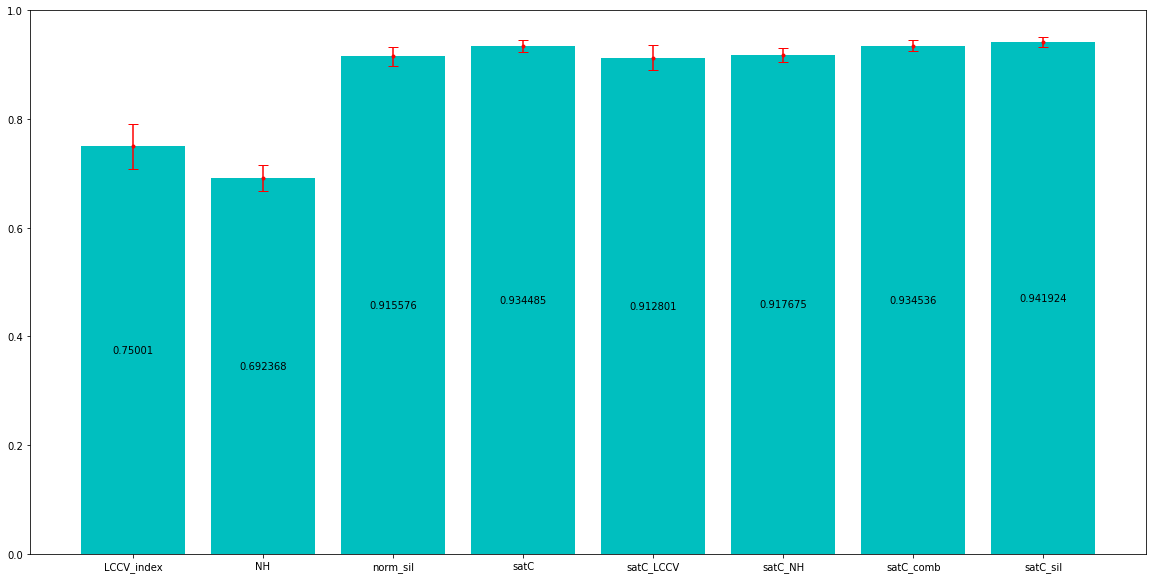

In [221]:
plt.figure(figsize=(20,10))
rects = plt.bar(legend_vals, np.mean(kmr, axis=0), color='c')
plt.ylim([0,1])
error_min, error_max = [], []
for i in np.arange(len(legend_vals)):
    KM_CI_95 = st.norm.interval(alpha=0.95, loc=np.mean(kmr[:,i]), scale=st.sem(kmr[:,i]))
    error_min.append(np.mean(kmr, axis=0)[i] - KM_CI_95[0])
    error_max.append(KM_CI_95[1] - np.mean(kmr, axis=0)[i])
y_error = [error_min, error_max]
plt.bar_label(rects, padding=0, label_type='center')
plt.errorbar(legend_vals, np.mean(kmr, axis=0), yerr=y_error, c='r',fmt='.', capsize=5)
plt.show()

8


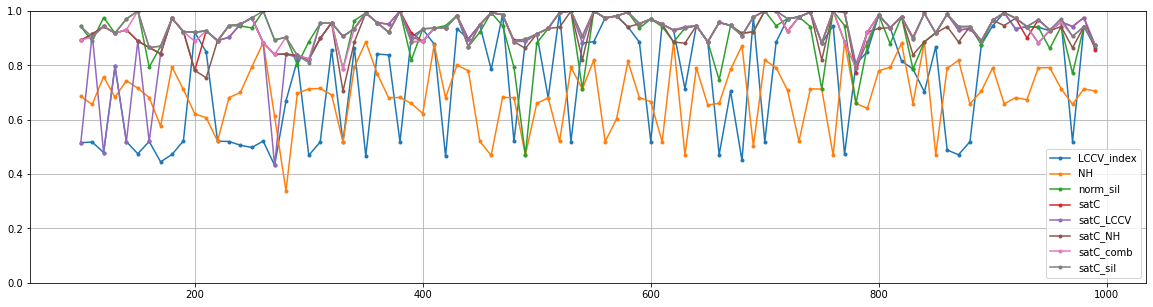

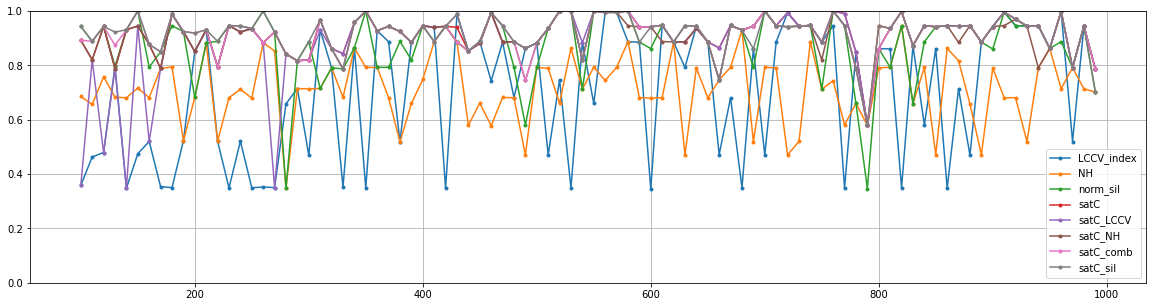

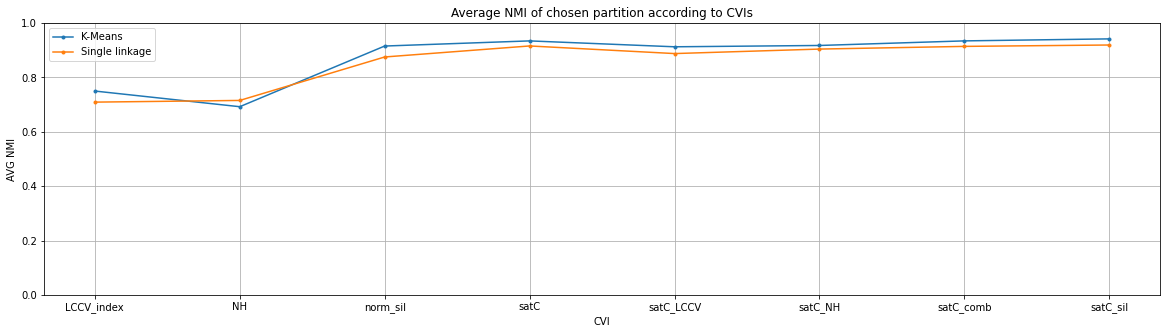

In [189]:
import matplotlib.pyplot as plt

print(len(legend_vals))

plt.figure(figsize=(20,5))
for i in np.arange(kmr.shape[1]):
    plt.ylim([0,1])
    plt.plot(np.arange(100, 1000, 10), kmr[:,i],'.-', label=legend_vals[i])
    plt.grid('on')
    plt.legend()


plt.figure(figsize=(20,5))
for i in np.arange(kmr.shape[1]):
    plt.ylim([0,1])
    plt.plot(np.arange(100, 1000, 10), slr[:,i],'.-', label=legend_vals[i])
    plt.grid('on')
    plt.legend()

plt.figure(figsize=(20,5))
plt.title('Average NMI of chosen partition according to CVIs')
plt.ylabel('AVG NMI')
plt.xlabel('CVI')
plt.ylim([0,1])
plt.plot(legend_vals, np.mean(kmr, axis=0),'.-', label='K-Means')
plt.plot(legend_vals, np.mean(slr, axis=0),'.-', label='Single linkage')
plt.grid('on')
plt.legend()
    